<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [102]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [103]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z * torch.exp(-self.s)
        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [104]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

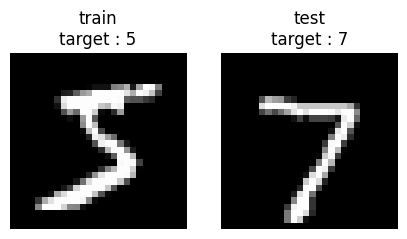

In [105]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [106]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))

model = NICE(input_dim=data_dim, hidden_layer=64, num_flows=15)

train_loader = DataLoader(train_data, batch_size=5000, shuffle=True)


In [107]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1091.4835408528645
Epoch :  2   -----------> Loss :  997.6963907877604
Epoch :  3   -----------> Loss :  905.6798502604166
Epoch :  4   -----------> Loss :  814.0391591389974
Epoch :  5   -----------> Loss :  723.6631673177084
Epoch :  6   -----------> Loss :  635.0898793538412
Epoch :  7   -----------> Loss :  549.8942565917969
Epoch :  8   -----------> Loss :  464.9267323811849
Epoch :  9   -----------> Loss :  381.4833017985026
Epoch :  10   -----------> Loss :  300.9627329508464
Epoch :  11   -----------> Loss :  225.9231274922689
Epoch :  12   -----------> Loss :  151.56617863972983
Epoch :  13   -----------> Loss :  81.27022329966228
Epoch :  14   -----------> Loss :  16.37449061870575
Epoch :  15   -----------> Loss :  -50.00456555684408
Epoch :  16   -----------> Loss :  -111.39458020528157
Epoch :  17   -----------> Loss :  -157.85769526163736
Epoch :  18   -----------> Loss :  -216.12097295125326
Epoch :  19   -----------> Loss :  -242.331167

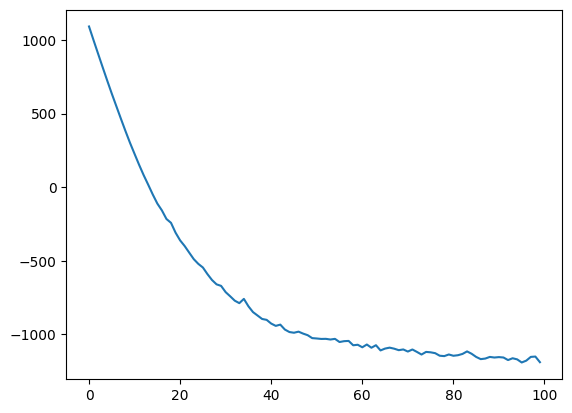

In [108]:
plt.plot(COST)

In [109]:
test = prior.sample((50,))
test

tensor([[ 0.5540,  0.7124, -0.0116,  ...,  0.8300, -0.5143, -0.7089],
        [ 1.3000, -0.7430, -0.2257,  ...,  0.1218, -0.7866,  0.0702],
        [ 0.6554, -0.5591, -0.4663,  ...,  1.4927, -0.4221, -1.0200],
        ...,
        [ 0.5575,  1.0608,  0.2314,  ..., -0.2837,  0.3559,  0.6195],
        [-0.7367, -1.0465, -0.0843,  ...,  2.1774, -0.0484,  0.5614],
        [ 0.6987,  1.7966, -0.5474,  ..., -1.2464, -0.6912,  0.0392]])

In [110]:
sonuc = model.f_inv(test)
sonuc

tensor([[-6.1625e-04,  8.8159e-03, -6.2905e-04,  ...,  4.9649e-03,
         -2.7060e-03, -4.0620e-03],
        [ 1.8286e-03, -2.7766e-04, -2.0782e-03,  ...,  9.2700e-04,
         -4.6111e-03,  5.7387e-04],
        [ 7.8958e-05,  7.2823e-04, -2.8868e-03,  ...,  9.1241e-03,
         -1.9278e-03, -5.5461e-03],
        ...,
        [-2.9311e-04,  1.1493e-02,  3.1439e-04,  ..., -1.8702e-03,
          3.2325e-03,  3.8422e-03],
        [-5.6668e-03, -1.6982e-03, -1.0795e-03,  ...,  1.2970e-02,
         -2.8551e-05,  3.3275e-03],
        [ 1.0344e-04,  1.7431e-02, -3.6014e-03,  ..., -6.9517e-03,
         -3.7913e-03,  5.5161e-04]], grad_fn=<CopySlices>)

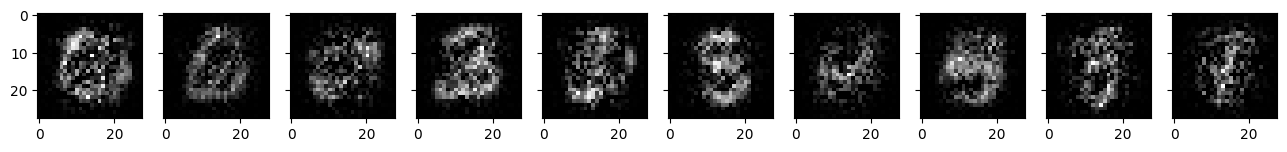

In [111]:
test = prior.sample((10,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(16, 8))

for i in range(0,10):

    axs[i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((28,28)), cmap='gray')
    #axs[i].axis('off')

fig.show()